# 시계열 시뮬레이션
동일한 시계열에서는 두 데이터가 서로 다른 시간에 일어나므로 정확히 비교하는 것은 어렵다. 그렇기 때문에 특정 시간에 발생 가능한 일을 예측하려면 시뮬레이션이 필요하다.

시뮬레이션과 예측은 둘다 시스템의 유동성과 파라미터에 대한 가설을 세운 다음 가설을 기반으로 생성될 데이터를 추론한다. 하지만 다음과 같은 차이점이 존재한다.
- 정성적 관측을 예측보다 시뮬레이션에 통합하는 것이 더 쉬울 수 있다.
- 시뮬레이션은 확장 가능한 형태로 실행되므로 여러 가지 시나리오를 관찰할 수 있다. 반면에 예측은 시뮬레이션보다 더 신중하게 처리되어야 한다.
- 시뮬레이션은 가상이므로 실제 자원의 투입이 없어 예측에 비해 위험 부담이 적다.

In [1]:
import numpy as np
import pandas as pd

In [39]:
years = list(map(str,range(2014,2019)))
status = ['bronze','silver','gold','inactive']

memberYears = np.random.choice(years, 1000, p=[0.1, 0.1, 0.15, 0.30, 0.35])
memberStatus = np.random.choice(status, 1000, p=[0.5, 0.3, 0.1, 0.1])

yearJoined = pd.DataFrame({'yearJoined':memberYears,
                          'memberStats':memberStatus})

In [40]:
yearJoined.groupby('yearJoined')['memberStats'].value_counts(normalize = True).map(lambda x:np.round(x,3))*100

yearJoined  memberStats
2014        bronze         48.0
            silver         32.7
            gold           11.2
            inactive        8.2
2015        bronze         55.0
            silver         26.6
            gold            9.2
            inactive        9.2
2016        bronze         48.3
            silver         29.1
            gold           14.6
            inactive        7.9
2017        bronze         49.2
            silver         29.7
            gold           10.7
            inactive       10.4
2018        bronze         48.9
            silver         34.8
            inactive        9.5
            gold            6.8
Name: memberStats, dtype: float64

주별로 회원의 이메일 열람 시점을 나타내는 테이블을 만든다.<br>
이메일에 관한 회원들의 행동 패턴은 다음 세 가지로 정의된다.
- 열람한 적 없음
- 일정 수준의 이메일 열람 및 참여율
- 참여 수준의 증가 또는 감소

In [23]:
# 매주 발송하는 이메일의 양
NUM_EMAILS_SENT_WEEKLY = 3

# 서로 다른 패턴을 위한 몇 가지 함수를 정의한다.
def never_opens(period_rng):
    return []
def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened
def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))
def decreasinf_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return []
    times = np.random.randint(0, len(period_rng), int(0.1* len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng),2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
            num_opened[prd:(prd+2)] = np.random.binomial(n,p,2)
            p = np.max(np.min(1,p*fac),0)
        except:
            num_opened[prd] = np.random.binomial(n,p,1)
    for t in times:
        num_opened[t] = 0
    return num_opened

- 이메일을 한 번도 열람하지 않음 : never_opens()
- 매주 같은 양의 이메일을 열람 : constant_open_rate()
- 매주 열람한 이메일의 양이 줄어드는 회원 : decreasing_open_rate()
- 매주 열람한 이메일의 양이 늘어나는 회원 : increasing_open_rate()

너무 단순한 시뮬레이션은 깊은 통찰을 주지 못하므로, 회원의 행동을 정의하는 가설을 고려한 모델을 만들고 그 가설에 기반한 시뮬레이션이 실제 데이터와 맞아떨어지는지를 검증해야한다.

- 회원 자격의 기간에 따라서 기부의 전체 횟수를 정함
- 회원별 재정 상태를 만들었는데,이는 한 사람의 안정적인 재산의 양이 기부의 양에 밀접한 관련이 있다는 가설에 기반

In [47]:
def produce_donations(period_rng, member_behavior, num_emails, use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max( min(member_gives_idx,len(donation_amounts)-2),  1)
    
    num_times_gave = np.random.poisson(2)*(2018-member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member':[], 'amount':[], 'timestamp':[]})
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, 0.3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({'member':[use_id], 'amount':[donation], 'timestamp':[ts]}))
                           
        if dons.shape[0] > 0:
            dons = dons[dons['amount'] != 0]
            # 기부액이 0인 경우는 보고하지 않음
            
            return dons

# 특정 주 내의 시간을 무작위로 고르기 위한 유틸리티 함수
def random_weekly_time_delta():
    days_of_week = list(range(7))
    hours_of_day = list(range(11,23))
    minute_of_hour = list(range(60))
    second_of_minute = list(range(60))
    return pd.Timedelta(str(np.random.choice(days_of_week)) + ' days')+\
            pd.Timedelta(str(np.random.choice(hours_of_day)) + ' hours')+\
            pd.Timedelta(str(np.random.choice(minute_of_hour)) + ' minutes')+\
            pd.Timedelta(str(np.random.choice(second_of_minute)) + ' seconds')

In [48]:
# 시뮬레이션에 필요한 코드를 한 군데로 모음
# 가입 이후의 시점에만 모든 사건이 발생할 수 있고, 이메일 열람 사건과 기부 사건이 약간의 관계를 갖도록 만들어준다.

behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasinf_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])

rng = pd.period_range('2015-02-14','2018-06-01',freq='W')
emails = pd.DataFrame({'member':[], 'week':[], 'emailsOpened':[]})
donations = pd.DataFrame({'member':[], 'amount':[], 'tunestamp':[]})

for idx in range(yearJoined.shape[0]):
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined)+\
                pd.Timedelta(str(np.random.randint(0,365))+' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
    
    member_rng = rng[rng > join_date]
    
    if len(member_rng) < 1:
        continue
    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame(
        {'member':[idx]*len(info),
        'week':[str(r.start_time) for r in member_rng],
        'emailsOpened':info}))
        donations = donations.append(
        produce_donations(member_rng, member_behaviors[idx],sum(info),idx, join_date.year))

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

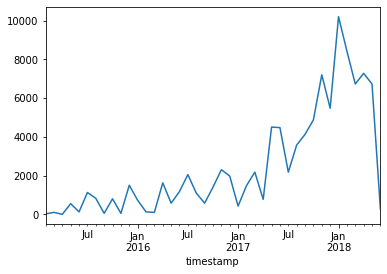

In [55]:
df = donations
df.set_index(pd.to_datetime(df.timestamp),inplace=True)
df.sort_index(inplace = True)
df.groupby(pd.Grouper(freq='M')).amount.sum().plot()

In [50]:
donations

,amount,member,timestamp,tunestamp
0,25.0,5.0,2018-03-07 13:25:09,NaN
0,25.0,6.0,2018-03-15 22:14:57,NaN
0,100.0,7.0,2017-09-25 13:10:03,NaN
0,1000.0,8.0,2016-04-14 17:03:04,NaN
0,25.0,10.0,2017-01-23 15:30:07,NaN
...,...,...,...,...
0,50.0,986.0,2018-01-15 12:11:09,NaN
0,50.0,990.0,2017-10-02 14:13:35,NaN
0,25.0,992.0,2016-08-19 18:12:22,NaN
0,25.0,995.0,2017-12-17 13:41:54,NaN
